In [2]:
# ===== Cell 0: Làm sạch Kaggle env + cài stack tối thiểu (tránh SciPy/TF) =====
import os, sys, subprocess, importlib

# Chặn Transformers đụng tới TF/Flax
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

def pip_uninstall(*pkgs):
    if not pkgs: 
        return
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "-q", *pkgs])
    except subprocess.CalledProcessError:
        pass

def pip_install(*pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "--upgrade", "--no-warn-script-location", *pkgs])

# Gỡ các gói dễ gây xung đột khi import transformers/diffusers
pip_uninstall(
    "scipy", "scikit-learn",
    "tensorflow", "tensorflow-cpu", "tensorflow-intel", "keras",
    "jax", "jaxlib"
)

# Cài gói “tối thiểu” đủ chạy pipeline
pip_install(
    "numpy==1.26.4",
    "ultralytics==8.3.225",
    "diffusers==0.31.0",
    "transformers==4.46.3",
    "accelerate==0.34.2",
    "safetensors==0.4.5",
    "opencv-python-headless==4.10.0.84",
    "onnxruntime==1.18.0",
    "rembg==2.0.57",
    "requests==2.32.3"
)

# Kiểm tra SciPy/TF đã thật sự biến mất
def _absent(modname):
    try:
        importlib.import_module(modname)
        print(f">> CẢNH BÁO: {modname} vẫn còn!")
    except Exception:
        print(f"{modname}: không có (OK)")

import numpy as _np
print("NumPy:", _np.__version__)
_absent("scipy")
_absent("sklearn")
_absent("tensorflow")
_absent("keras")


NumPy: 1.26.4
>> CẢNH BÁO: scipy vẫn còn!
sklearn: không có (OK)
tensorflow: không có (OK)
keras: không có (OK)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
woodwork 0.31.0 requires scikit-learn>=1.1.0, which is not installed.
boruta 0.4.3 requires scikit-learn>=0.17.1, which is not installed.
tpot 0.12.1 requires scikit-learn>=0.22.0, which is not installed.
shap 0.44.1 requires scikit-learn, which is not installed.
bayesian-optimization 3.1.0 requires scikit-learn>=1.0.0, which is not installed.
fastai 2.8.5 requires scikit-learn, which is not installed.
pyldavis 3.4.1 requires scikit-learn>=1.0.0, which is not installed.
scikit-plot 0.3.7 requires scikit-learn>=0.18, which is not installed.
nilearn 0.10.4 requires scikit-learn>=1.0.0, which is not installed.
eli5 0.13.0 requires scikit-learn>=0.20, which is not installed.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, which is not installed.
lime 0.2.0.1 requires scikit-learn>=0.18, which is not insta

In [3]:
# ===== Cell 1: Imports & Config =====
import os, io, math, requests, random
from pathlib import Path
from typing import Tuple, Optional

import torch
from PIL import Image, ImageOps
import numpy as np
import cv2

from ultralytics import YOLO
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, DDIMScheduler
from transformers import CLIPTokenizer, CLIPTextModel

# Thiết bị
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype  = torch.float16 if device == "cuda" else torch.float32
print("Device:", device, "| DType:", dtype)

# Thư mục làm việc
WORK = Path("/kaggle/working")
(IMAGES := WORK / "tryon_cache").mkdir(parents=True, exist_ok=True)

# Random seed cho reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed_all(SEED)


Device: cuda | DType: torch.float16


In [14]:
# ===== Cell 2: Load YOLO & ControlNet Pipeline =====

# 1) YOLO11n (COCO) — detect chó/mèo/người (IDs theo COCO)
yolo = YOLO("yolo11n.pt")  # auto-download
DOG_CAT_PERSON = [0, 15, 16]  # person=0, cat=15, dog=16

# 2) ControlNet (Canny) + SD1.5
#    - Base: "runwayml/stable-diffusion-v1-5" (ổn định, nhẹ hơn SDXL)
#    - ControlNet: "lllyasviel/sd-controlnet-canny"
BASE_MODEL = "Lykon/dreamshaper-8"
CANNY_MODEL = "lllyasviel/sd-controlnet-canny"

controlnet = ControlNetModel.from_pretrained(
    CANNY_MODEL, torch_dtype=dtype
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    BASE_MODEL,
    controlnet=controlnet,
    torch_dtype=dtype,
    safety_checker=None
)

# Lịch DDIM cho ảnh gọn hơn
pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)

if device == "cuda":
    pipe.enable_model_cpu_offload()  # tiết kiệm VRAM
pipe.enable_vae_tiling()

print("Models loaded ✔")


model_index.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/724 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/756 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Models loaded ✔


In [5]:
# ===== Cell 3: Utils =====
from IPython.display import display

def load_image(src: str | Path) -> Image.Image:
    """Tải ảnh từ URL hoặc local path."""
    s = str(src)
    if s.startswith("http://") or s.startswith("https://"):
        r = requests.get(s, timeout=20)
        r.raise_for_status()
        return Image.open(io.BytesIO(r.content)).convert("RGB")
    return Image.open(s).convert("RGB")

def yolo_crop_subject(img: Image.Image,
                      classes=DOG_CAT_PERSON,
                      conf=0.35,
                      pad_ratio=0.08) -> Optional[Image.Image]:
    """Detect subject (chó/mèo/người). Trả về crop lớn nhất (ưu tiên chó/mèo)."""
    res = yolo.predict(img, classes=classes, conf=conf, verbose=False)[0]
    if res.boxes is None or res.boxes.shape[0] == 0:
        return None

    # Ưu tiên dog/cat, nếu không có thì lấy box lớn nhất
    boxes = res.boxes.xyxy.cpu().numpy().astype(int)
    clses = res.boxes.cls.cpu().numpy().astype(int)

    pri = [i for i,c in enumerate(clses) if c in (15,16)]  # cat/dog
    idxs = pri if len(pri)>0 else list(range(len(boxes)))

    # lấy box to nhất
    best = max(idxs, key=lambda i: (boxes[i][2]-boxes[i][0])*(boxes[i][3]-boxes[i][1]))
    x1,y1,x2,y2 = boxes[best]
    W,H = img.size
    pad = int(max(W,H)*pad_ratio)
    x1 = max(0, x1 - pad); y1 = max(0, y1 - pad)
    x2 = min(W, x2 + pad); y2 = min(H, y2 + pad)
    if x2<=x1 or y2<=y1: return None
    return img.crop((x1,y1,x2,y2))

def canny_from_pil(img: Image.Image,
                   low=100, high=200) -> Image.Image:
    """Tạo ảnh Canny từ PIL → PIL (RGB)"""
    arr = np.array(img)
    arr = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(arr, low, high)
    edges = np.stack([edges]*3, axis=-1)  # 3 kênh
    return Image.fromarray(edges)

def remove_bg(img: Image.Image) -> Image.Image:
    """
    Xóa nền sản phẩm, luôn trả về RGBA.
    Hỗ trợ mọi kiểu trả về của rembg (PIL.Image | bytes | numpy array).
    Nếu ảnh đã có alpha (PNG trong suốt), giữ nguyên.
    """
    # Nếu đã có alpha & có pixel trong suốt -> dùng luôn
    if img.mode in ("RGBA", "LA"):
        try:
            alpha = img.split()[-1]
            if np.array(alpha).min() < 255:
                return img.convert("RGBA")
        except Exception:
            pass

    from rembg import remove as _rembg_remove
    out = _rembg_remove(img)  # trên Kaggle hiện trả về PIL.Image

    # Trường hợp 1: rembg trả về PIL.Image
    if isinstance(out, Image.Image):
        return out.convert("RGBA")

    # Trường hợp 2: rembg trả về bytes
    if isinstance(out, (bytes, bytearray)):
        return Image.open(io.BytesIO(out)).convert("RGBA")

    # Trường hợp 3: rembg trả về numpy array
    if isinstance(out, np.ndarray):
        return Image.fromarray(out).convert("RGBA")

    # Nếu có kiểu lạ, báo rõ để còn xử lý
    raise TypeError(f"Unsupported rembg output type: {type(out)}")


def center_pad_resize(img: Image.Image, size=768) -> Image.Image:
    """Đưa ảnh về canvas vuông size×size (giữ tỉ lệ, padding)."""
    return ImageOps.pad(img, (size, size), method=Image.BICUBIC, color=(255,255,255), centering=(0.5,0.5))

def show_row(title: str, images: list[Tuple[str, Image.Image]], max_w=256):
    print(title)
    for name, im in images:
        print("-", name)
        display(im.resize((max_w, int(im.height*max_w/im.width))))


In [15]:
# ===== Cell 4: Cấu hình đầu vào =====

# Ảnh input
USER_IMAGE    = "https://www.tournhatban.net.vn/images/camnangdulich/tintucdulich/shiba/shiba-3.jpg"
PRODUCT_IMAGE = "/kaggle/input/datatesttask2/batancham.png"

# ——— Mô tả bằng tiếng Anh (SD hiểu tốt hơn) ———
# Bạn có thể sửa lại PRODUCT_NAME_EN cho từng sản phẩm:
PRODUCT_NAME_EN = "a strawberry-shaped slow feeder dog bowl"
# Ví dụ khác:
#   collar: "a red pet collar with a small bell"
#   muzzle: "a pink soft muzzle for dogs"
#   training bell: "a colorful set of training bells for dogs"

BASE_SUBJECT_EN = (
    "a single dog standing on the ground, full body, facing the camera"
)
SCENE_HINT_EN = "outdoor park, grass on the ground"
STYLE_HINT_EN = "cute pastel anime illustration, chibi style, high quality, soft shading"

# Prompt sinh ảnh (sẽ ghép trong Cell 5)
#   -> tạm thời để trống ở đây, tí nữa build trong Cell 5

# Tham số sinh ảnh
OUT_SIZE   = 768
GUIDANCE   = 8.5         # đẩy text influence mạnh hơn
STEPS      = 24          # nhiều step hơn chút
CTRL_SCALE = 0.8         # độ mạnh ControlNet (0.5–1.0, cứ 0.7–0.8 trước)
NUM_SAMPLES = 3          # sinh 3 ảnh để chọn
NEGATIVE = (
    "low quality, blurry, bad anatomy, deformed, "
    "extra legs, extra heads, extra animals, horse, human, "
    "cropped, cut off, text, watermark, logo, "
    "missing bowl, no bowl, empty ground"
)


Tiền xử lý
- Ảnh người dùng (crop)


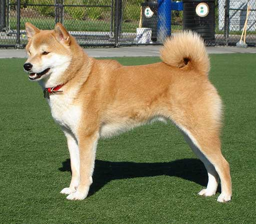

- Canny từ crop


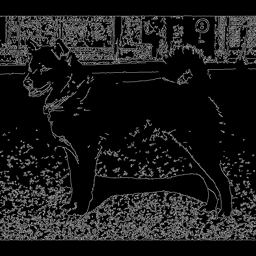

- Sản phẩm RGBA


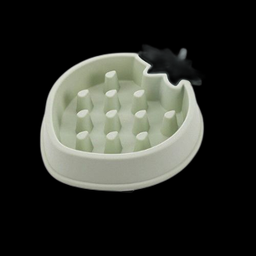

Token indices sequence length is longer than the specified maximum sequence length for this model (85 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['chibi style, high quality, soft shading']


Prompt dùng để gen:
 a single dog standing on the ground, full body, facing the camera, outdoor park, grass on the ground, the dog is interacting with a strawberry-shaped slow feeder dog bowl, a strawberry-shaped slow feeder dog bowl is clearly visible in front of the dog, the scene must show a strawberry-shaped slow feeder dog bowl on the ground, cute pastel anime illustration, chibi style, high quality, soft shading 



  0%|          | 0/24 [00:00<?, ?it/s]

Kết quả sinh ảnh
- Ảnh sinh ra #1


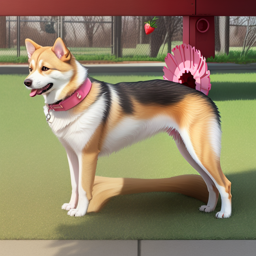

- Ảnh sinh ra #2


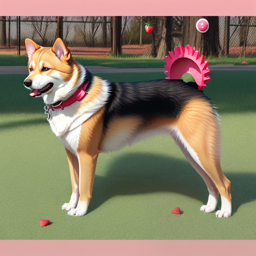

- Ảnh sinh ra #3


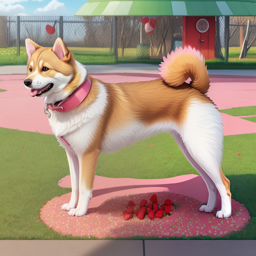

Saved ảnh #1: /kaggle/working/tryon_result_1.png


In [16]:
# ===== Cell 5: Inference =====
# 1) Load ảnh
try:
    img_user = load_image(USER_IMAGE)
except Exception as e:
    raise RuntimeError(f"Không tải được USER_IMAGE: {e}")

try:
    img_prod = load_image(PRODUCT_IMAGE)
except Exception as e:
    raise RuntimeError(f"Không tải được PRODUCT_IMAGE: {e}")

# 2) Detect & crop subject
crop = yolo_crop_subject(img_user, conf=0.35)
if crop is None:
    raise RuntimeError("YOLO không phát hiện chó/mèo/người trong ảnh. Hãy thử ảnh khác rõ chủ thể hơn.")

# 3) Làm sạch sản phẩm (xóa nền), chuẩn hóa kích thước
prod_rgba = remove_bg(img_prod)  # RGBA (hiện giờ ta chỉ hiển thị cho người xem)
crop_std  = center_pad_resize(crop, OUT_SIZE)

# 4) Tạo Canny từ crop (là điều kiện cho ControlNet)
cond = canny_from_pil(crop_std, low=100, high=200)

show_row("Tiền xử lý", [
    ("Ảnh người dùng (crop)", crop),
    ("Canny từ crop", cond),
    ("Sản phẩm RGBA", prod_rgba.convert("RGB"))
])

# 5) Xây prompt
prompt = (
    f"{BASE_SUBJECT_EN}, "
    f"{SCENE_HINT_EN}, "
    f"the dog is interacting with {PRODUCT_NAME_EN}, "
    f"{PRODUCT_NAME_EN} is clearly visible in front of the dog, "
    f"the scene must show {PRODUCT_NAME_EN} on the ground, "
    f"{STYLE_HINT_EN}"
)

print("Prompt dùng để gen:\n", prompt, "\n")

# 6) Gọi ControlNet pipeline – sinh nhiều ảnh để chọn
generator = torch.Generator(device=device).manual_seed(SEED)
result = pipe(
    prompt=prompt,
    negative_prompt=NEGATIVE,
    image=cond,                         # ảnh điều kiện (Canny)
    num_inference_steps=STEPS,
    guidance_scale=GUIDANCE,
    generator=generator,
    controlnet_conditioning_scale=CTRL_SCALE,
    num_images_per_prompt=NUM_SAMPLES,  # sinh 3 ảnh
)

images = result.images

# 7) Hiển thị kết quả
rows = [(f"Ảnh sinh ra #{i+1}", img) for i, img in enumerate(images)]
show_row("Kết quả sinh ảnh", rows)

# Lưu ảnh đầu tiên (nếu muốn)
out_path = WORK / "tryon_result_1.png"
images[0].save(out_path, quality=95)
print("Saved ảnh #1:", out_path)


# ***Phía dưới là inference cũ*** -------------------------------------------------------------------------

Tiền xử lý
- Ảnh người dùng (crop)


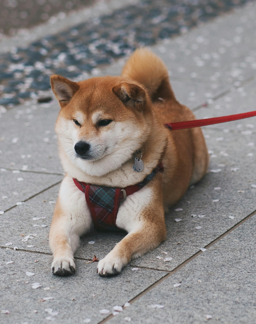

- Sản phẩm RGBA


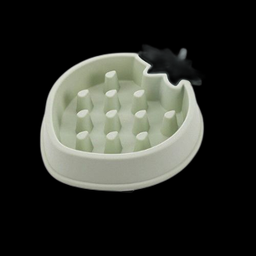

- Canny từ crop


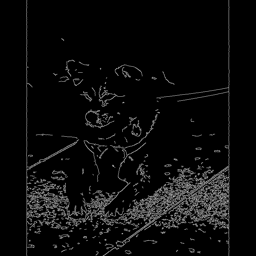

Prompt: a single shiba inu dog, full body, standing on grass, looking at the camera, cute, dog, dog, dog, wearing or interacting with a strawberry-shaped slow feeder dog bowl. cute illustration, soft lighting, pastel colors, high quality
Negative: low quality, blurry, bad anatomy, extra limbs, extra legs, extra heads, deformed, mutilated, two heads, mutation, horse, horses, pony, text, watermark, logo


  0%|          | 0/28 [00:00<?, ?it/s]

Kết quả sinh ảnh
- Ảnh generative (SD1.5 + ControlNet Canny)


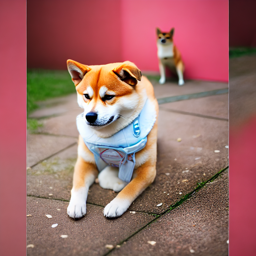

Saved: /kaggle/working/tryon_result.png


In [13]:
# ===== Cell 5: Inference (ControlNet-Canny) =====

# 1) Load ảnh
try:
    img_user = load_image(USER_IMAGE)
except Exception as e:
    raise RuntimeError(f"Không tải được USER_IMAGE: {e}")

try:
    img_prod = load_image(PRODUCT_IMAGE)
except Exception as e:
    raise RuntimeError(f"Không tải được PRODUCT_IMAGE: {e}")

# 2) Detect & crop subject
crop = yolo_crop_subject(img_user, conf=0.35)
if crop is None:
    raise RuntimeError("YOLO không phát hiện chó/mèo/người trong ảnh. Hãy thử ảnh khác rõ chủ thể hơn.")

# 3) Xử lý sản phẩm & ảnh user (chủ yếu để log, chưa dùng vào model)
prod_rgba = remove_bg(img_prod)      # RGBA (cho tương lai, ví dụ on-ground)
crop_std  = center_pad_resize(crop, OUT_SIZE)

# 4) Tạo Canny từ crop (đưa vào ControlNet)
cond = canny_from_pil(crop_std, low=100, high=200)

show_row("Tiền xử lý", [
    ("Ảnh người dùng (crop)", crop),
    ("Sản phẩm RGBA", prod_rgba.convert("RGB")),
    ("Canny từ crop", cond),
])

# 5) Prompt tiếng Anh – bám chặt vào DOG + PRODUCT
prompt = (
    f"{BASE_SUBJECT}, wearing or interacting with a {PRODUCT_NAME_EN}. "
    f"{STYLE_HINT_EN}"
)

print("Prompt:", prompt)
print("Negative:", NEGATIVE)

# 6) Gọi ControlNet pipeline
generator = torch.Generator(device=device).manual_seed(SEED)

result = pipe(
    prompt=prompt,
    negative_prompt=NEGATIVE,
    image=cond,                        # condition = Canny
    num_inference_steps=STEPS,
    guidance_scale=GUIDANCE,
    generator=generator,
    controlnet_conditioning_scale=CTRL_SCALE,  # quan trọng
)

out_img = result.images[0]

# 7) Hiển thị kết quả
show_row("Kết quả sinh ảnh", [
    ("Ảnh generative (SD1.5 + ControlNet Canny)", out_img)
])

# Lưu nếu cần
out_path = WORK / "tryon_result.png"
out_img.save(out_path, quality=95)
print("Saved:", out_path)


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Img2Img pipeline loaded ✔
Tiền xử lý
- Ảnh người dùng (crop)


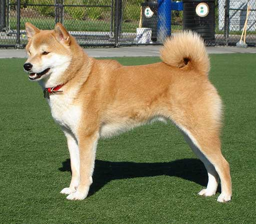

- Canny từ crop (chỉ để tham khảo)


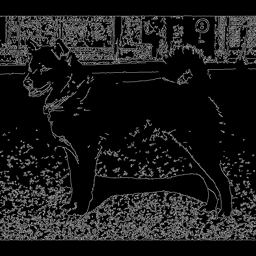

- Sản phẩm RGBA


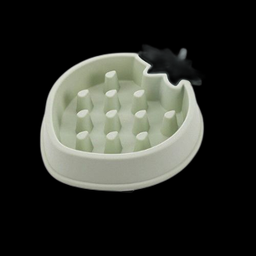

Token indices sequence length is longer than the specified maximum sequence length for this model (176 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['ó , khung cảnh sáng , rõ nét , tập trung vào chó và sản phẩm , phong cách chibi , đáng yêu , nét vẽ hoạt hình mềm mại , màu tươi sáng']


  0%|          | 0/12 [00:00<?, ?it/s]

Kết quả sinh ảnh (img2img)
- Ảnh generative (SD1.5 img2img)


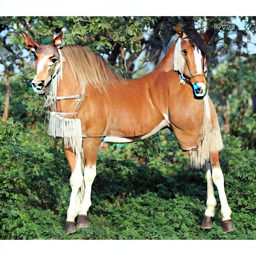

Saved: /kaggle/working/tryon_result.png


In [9]:
# ===== Cell 5: Inference (phiên bản generative img2img, không ép ControlNet) =====
from diffusers import StableDiffusionImg2ImgPipeline

# 0) Khởi tạo pipeline img2img (dùng chung BASE_MODEL, dtype, device đã cấu hình ở trên)
try:
    pipe_i2i  # nếu đã tạo rồi thì dùng lại, tránh tải nhiều lần
except NameError:
    pipe_i2i = StableDiffusionImg2ImgPipeline.from_pretrained(
        BASE_MODEL,
        torch_dtype=dtype,
        safety_checker=None
    )
    if device == "cuda":
        pipe_i2i = pipe_i2i.to(device)
    pipe_i2i.enable_vae_tiling()
    print("Img2Img pipeline loaded ✔")

# 1) Load ảnh
try:
    img_user = load_image(USER_IMAGE)
except Exception as e:
    raise RuntimeError(f"Không tải được USER_IMAGE: {e}")

try:
    img_prod = load_image(PRODUCT_IMAGE)
except Exception as e:
    raise RuntimeError(f"Không tải được PRODUCT_IMAGE: {e}")

# 2) Detect & crop subject
crop = yolo_crop_subject(img_user, conf=0.35)
if crop is None:
    raise RuntimeError(
        "YOLO không phát hiện chó/mèo/người trong ảnh. "
        "Hãy thử ảnh khác rõ chủ thể hơn."
    )

# 3) Làm sạch sản phẩm (xóa nền) + chuẩn hóa kích thước crop
prod_rgba = remove_bg(img_prod)          # dùng để hiển thị cho user xem
crop_std  = center_pad_resize(crop, OUT_SIZE)

# 4) Tạo Canny từ crop chỉ để quan sát (KHÔNG đưa vào model nữa)
cond = canny_from_pil(crop_std, low=100, high=200)

show_row("Tiền xử lý", [
    ("Ảnh người dùng (crop)", crop),
    ("Canny từ crop (chỉ để tham khảo)", cond),
    ("Sản phẩm RGBA", prod_rgba.convert("RGB"))
])

# 5) Prompt: mô tả cảnh GENERATIVE – chó + sản phẩm trên nền
#    => vì là đồ đặt dưới đất (bát ăn, chuông huấn luyện, vv.) nên mô tả “đặt trước mặt”
prompt = (
    "một chú chó dễ thương đang tương tác với "
    f"{PRODUCT_NAME} đặt trên mặt đất phía trước nó, "
    "khung cảnh sáng, rõ nét, tập trung vào chó và sản phẩm, "
    f"{STYLE_HINT}"
)

# Bạn có thể chỉnh thêm NEGATIVE nếu muốn ảnh sạch hơn
negative_prompt = NEGATIVE + ", distorted, deformed dog, cut off body"

# 6) Gọi img2img – dùng crop_std làm init image
generator = torch.Generator(device=device).manual_seed(SEED)

result = pipe_i2i(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=crop_std,              # ảnh gốc của user (crop)
    strength=0.7,                # 0.4 → gần ảnh gốc, 0.8 → vẽ mới nhiều hơn
    guidance_scale=GUIDANCE,
    num_inference_steps=STEPS,
    generator=generator,
)

out_img = result.images[0]

# 7) Hiển thị kết quả
show_row("Kết quả sinh ảnh (img2img)", [
    ("Ảnh generative (SD1.5 img2img)", out_img)
])

# Lưu nếu cần
out_path = WORK / "tryon_result.png"
out_img.save(out_path, quality=95)
print("Saved:", out_path)


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 263GB/s]


Tiền xử lý
- Ảnh người dùng (crop)


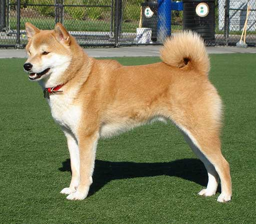

- Canny từ crop


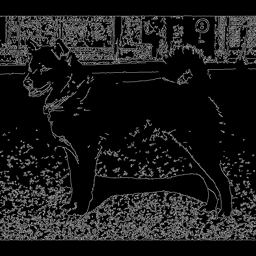

- Sản phẩm RGBA


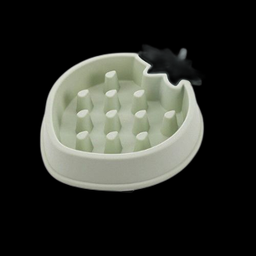

Token indices sequence length is longer than the specified maximum sequence length for this model (105 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['t hình mềm mại , màu tươi sáng']


  0%|          | 0/18 [00:00<?, ?it/s]

Kết quả sinh ảnh
- Ảnh sinh ra (ControlNet-Canny + SD1.5)


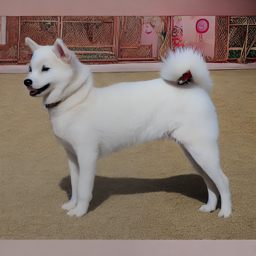

Saved: /kaggle/working/tryon_result.png


In [7]:
# ===== Cell 5: Inference =====
# 1) Load ảnh
try:
    img_user = load_image(USER_IMAGE)
except Exception as e:
    raise RuntimeError(f"Không tải được USER_IMAGE: {e}")

try:
    img_prod = load_image(PRODUCT_IMAGE)
except Exception as e:
    raise RuntimeError(f"Không tải được PRODUCT_IMAGE: {e}")

# 2) Detect & crop subject
crop = yolo_crop_subject(img_user, conf=0.35)
if crop is None:
    raise RuntimeError("YOLO không phát hiện chó/mèo/người trong ảnh. Hãy thử ảnh khác rõ chủ thể hơn.")

# 3) Làm sạch sản phẩm (xóa nền), chuẩn hóa kích thước
prod_rgba = remove_bg(img_prod)  # RGBA
crop_std  = center_pad_resize(crop, OUT_SIZE)

# 4) Tạo Canny từ crop (là điều kiện cho ControlNet)
cond = canny_from_pil(crop_std, low=100, high=200)

show_row("Tiền xử lý", [
    ("Ảnh người dùng (crop)", crop),
    ("Canny từ crop", cond),
    ("Sản phẩm RGBA", prod_rgba.convert("RGB"))
])

# 5) Prompt: miêu tả chủ thể + sản phẩm + style cute
prompt = (
    f"chú chó đeo {PRODUCT_NAME}, nhìn thẳng camera, "
    f"biểu cảm dễ thương, {STYLE_HINT}"
)

# 6) Gọi ControlNet pipeline
generator = torch.Generator(device=device).manual_seed(SEED)
result = pipe(
    prompt=prompt,
    negative_prompt=NEGATIVE,
    image=cond,                # ảnh điều kiện (Canny)
    num_inference_steps=STEPS,
    guidance_scale=GUIDANCE,
    generator=generator
)

out_img = result.images[0]

# 7) Hiển thị kết quả
show_row("Kết quả sinh ảnh", [
    ("Ảnh sinh ra (ControlNet-Canny + SD1.5)", out_img)
])

# Lưu nếu cần
out_path = WORK / "tryon_result.png"
out_img.save(out_path, quality=95)
print("Saved:", out_path)


In [ ]:
# ===== Cell 6: Biến thể (tuỳ chọn) =====
variants = []
for sd in [7, 21, 42, 77]:
    gen = torch.Generator(device=device).manual_seed(sd)
    imgv = pipe(
        prompt=prompt,
        negative_prompt=NEGATIVE,
        image=cond,
        num_inference_steps=STEPS,
        guidance_scale=GUIDANCE,
        generator=gen
    ).images[0]
    variants.append((f"seed={sd}", imgv))

show_row("Biến thể", variants)
